## library

In [30]:
import os
import glob
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import numpy as np
import random
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint, uniform, loguniform

import xgboost as xgb
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, f1_score, roc_auc_score
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

### Config

In [31]:
start_date_str = '2015-01-01'
end_date_str = '2017-03-01'
def generate_first_of_month_dates(start_date_str, end_date_str):
    # Convert the date strings to datetime objects
    start_date = datetime.strptime(start_date_str, "%Y-%m-%d")
    end_date = datetime.strptime(end_date_str, "%Y-%m-%d")
    
    # List to store the first of month dates
    first_of_month_dates = []

    # Start from the first of the month of the start_date
    current_date = datetime(start_date.year, start_date.month, 1)
    while current_date <= end_date:
        current_year = current_date.year
        current_month = current_date.month
        if current_month <10:
            current_date_str = f"{current_year}_0{current_month}_01"
        else:
            current_date_str = f"{current_year}_{current_month}_01"
        # Append the date in yyyy-mm-dd format
        first_of_month_dates.append(current_date_str)
        
        # Move to the first of the next month
        if current_date.month == 12:
            current_date = datetime(current_date.year + 1, 1, 1)
        else:
            current_date = datetime(current_date.year, current_date.month + 1, 1)
    

    return first_of_month_dates

dates_str = generate_first_of_month_dates(start_date_str, end_date_str)
print(dates_str)

['2015_01_01', '2015_02_01', '2015_03_01', '2015_04_01', '2015_05_01', '2015_06_01', '2015_07_01', '2015_08_01', '2015_09_01', '2015_10_01', '2015_11_01', '2015_12_01', '2016_01_01', '2016_02_01', '2016_03_01', '2016_04_01', '2016_05_01', '2016_06_01', '2016_07_01', '2016_08_01', '2016_09_01', '2016_10_01', '2016_11_01', '2016_12_01', '2017_01_01', '2017_02_01', '2017_03_01']


### Load Gold Tables

#### Labels

In [32]:
### Ingesting data from Google Cloud Storage

bucket_name = "cs611_mle"
label_path_in_bucket = "Gold Layer/labels.csv"
label_gcs_path = f"gs://{bucket_name}/{label_path_in_bucket}"

label_pdf = pd.read_csv(label_gcs_path)
label_pdf

,msno,membership_start_date,membership_expire_date,churn
0,++3Z+W8OPnpbHYfrKwqRKN1bF83XEbxjdYUolhGdHZg=,2015-01-10,2015-02-09,0
1,++3Z+W8OPnpbHYfrKwqRKN1bF83XEbxjdYUolhGdHZg=,2015-02-07,2015-03-09,0
2,++3Z+W8OPnpbHYfrKwqRKN1bF83XEbxjdYUolhGdHZg=,2015-03-10,2015-04-09,0
3,++3Z+W8OPnpbHYfrKwqRKN1bF83XEbxjdYUolhGdHZg=,2015-04-09,2015-05-09,0
4,++3Z+W8OPnpbHYfrKwqRKN1bF83XEbxjdYUolhGdHZg=,2015-06-04,2015-07-04,0
...,...,...,...,...
2821182,zzz1Dc3P9s53HAowRTrm3fNsWju5yeN4YBfNDq7Z99Q=,2016-10-25,2016-11-24,0
2821183,zzz1Dc3P9s53HAowRTrm3fNsWju5yeN4YBfNDq7Z99Q=,2016-11-24,2016-12-24,0
2821184,zzz1Dc3P9s53HAowRTrm3fNsWju5yeN4YBfNDq7Z99Q=,2016-12-25,2017-01-24,0
2821185,zzz1Dc3P9s53HAowRTrm3fNsWju5yeN4YBfNDq7Z99Q=,2017-01-25,2017-02-24,0


In [33]:
label_pdf = label_pdf.drop_duplicates(subset = ['msno', 'membership_start_date', 'membership_expire_date'], keep='first', inplace=False)
label_pdf

,msno,membership_start_date,membership_expire_date,churn
0,++3Z+W8OPnpbHYfrKwqRKN1bF83XEbxjdYUolhGdHZg=,2015-01-10,2015-02-09,0
1,++3Z+W8OPnpbHYfrKwqRKN1bF83XEbxjdYUolhGdHZg=,2015-02-07,2015-03-09,0
2,++3Z+W8OPnpbHYfrKwqRKN1bF83XEbxjdYUolhGdHZg=,2015-03-10,2015-04-09,0
3,++3Z+W8OPnpbHYfrKwqRKN1bF83XEbxjdYUolhGdHZg=,2015-04-09,2015-05-09,0
4,++3Z+W8OPnpbHYfrKwqRKN1bF83XEbxjdYUolhGdHZg=,2015-06-04,2015-07-04,0
...,...,...,...,...
2821182,zzz1Dc3P9s53HAowRTrm3fNsWju5yeN4YBfNDq7Z99Q=,2016-10-25,2016-11-24,0
2821183,zzz1Dc3P9s53HAowRTrm3fNsWju5yeN4YBfNDq7Z99Q=,2016-11-24,2016-12-24,0
2821184,zzz1Dc3P9s53HAowRTrm3fNsWju5yeN4YBfNDq7Z99Q=,2016-12-25,2017-01-24,0
2821185,zzz1Dc3P9s53HAowRTrm3fNsWju5yeN4YBfNDq7Z99Q=,2017-01-25,2017-02-24,0


In [34]:
label_pdf['membership_expire_date'] = pd.to_datetime(label_pdf['membership_expire_date'], format='%Y-%m-%d')
label_pdf['membership_start_date'] = pd.to_datetime(label_pdf['membership_start_date'], format='%Y-%m-%d')

/tmp/ipykernel_12288/170679981.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  label_pdf['membership_expire_date'] = pd.to_datetime(label_pdf['membership_expire_date'], format='%Y-%m-%d')
/tmp/ipykernel_12288/170679981.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  label_pdf['membership_start_date'] = pd.to_datetime(label_pdf['membership_start_date'], format='%Y-%m-%d')


In [35]:
label_pdf['plan_days'] = label_pdf['membership_expire_date'] -  label_pdf['membership_start_date']
label_pdf['plan_days'].unique()

/tmp/ipykernel_12288/915469325.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  label_pdf['plan_days'] = label_pdf['membership_expire_date'] -  label_pdf['membership_start_date']


<TimedeltaArray>
['30 days', '31 days']
Length: 2, dtype: timedelta64[ns]

In [36]:
# check label data
print("-------------LABEL INFORMATION-------------")
label_pdf.info()
print("-------------LABEL MISSING VALUE CHECK-------------")
# check missing values
label_pdf.isnull().sum()

-------------LABEL INFORMATION-------------
<class 'pandas.core.frame.DataFrame'>
Index: 2811276 entries, 0 to 2821186
Data columns (total 5 columns):
 #   Column                  Dtype          
---  ------                  -----          
 0   msno                    object         
 1   membership_start_date   datetime64[ns] 
 2   membership_expire_date  datetime64[ns] 
 3   churn                   int64          
 4   plan_days               timedelta64[ns]
dtypes: datetime64[ns](2), int64(1), object(1), timedelta64[ns](1)
memory usage: 128.7+ MB
-------------LABEL MISSING VALUE CHECK-------------


msno                      0
membership_start_date     0
membership_expire_date    0
churn                     0
plan_days                 0
dtype: int64

#### Features

In [37]:
from google.cloud import storage
import os

bucket_name = "cs611_mle"
feature_path_in_bucket = "datamart/gold/feature_store"
feature_gcs_path = [f"gs://{bucket_name}/{feature_path_in_bucket}/gold_featurestore_{date_str}.parquet/" for date_str in dates_str]

df_dict = {}
for path in feature_gcs_path:
    path_index = feature_gcs_path.index(path)
    date_str = dates_str[path_index]
    df_dict[f'df_{date_str}'] = pd.read_parquet(path)

In [38]:
feature_pdf = pd.concat(df_dict.values(), ignore_index=True)
feature_pdf

,msno,membership_start_date,membership_expire_date,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,is_cancel,...,songs_played_50_ratio,songs_played_75_ratio,songs_played_985_ratio,songs_completion_ratio,last_first_7_days_total_secs_ratio,city,gender,registered_via,registration_init_time,account_age
0,++pSqgOqSB8laOm+RTW6NLTqsMVQ0egh4Rs5+GOSJrQ=,2015-01-06,2015-02-05,41,30,149.0,119.0,1,2015-01-05,0,...,0.180851,0.074468,0.031915,0.489362,6.039049,5,male,7,2014-06-06,214
1,+/FpDPXcukKgEmdj/aCkhLlZPaPtdxycw1z11D2OukM=,2015-01-24,2015-02-23,41,30,149.0,119.0,1,2015-01-22,0,...,0.008726,0.006981,0.006981,0.944154,0.000000,1,na,7,2011-12-24,1127
2,+/ehcny76b1qm/wjQdzzp7sUps2DKTj/jM0P4qR/uzI=,2015-01-07,2015-02-07,40,31,149.0,149.0,1,2015-01-08,0,...,0.016556,0.026490,0.006623,0.844371,0.089451,11,na,9,2014-01-26,346
3,+03FlGdx1ny5jO9r7j09K1WGamqEGQvXxG5DfDk+5Sg=,2015-01-27,2015-02-27,40,31,149.0,149.0,1,2015-01-28,0,...,0.188830,0.074468,0.066489,0.449468,0.537696,13,na,9,2014-08-26,154
4,+04cPuRXH4W/GxWnS4qcA4vfohaRZmsCAstl6HBXdAM=,2015-01-08,2015-02-08,40,31,149.0,149.0,1,2015-01-08,0,...,0.018868,0.018868,0.000000,0.905660,4.409878,6,female,9,2008-09-05,2316
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3083151,rIvVL1XCPoJEDlJIhNJ+1OVHcYd8eazlNQbQRvo6WpA=,2017-03-01,2017-03-31,33,30,149.0,149.0,1,2017-02-28,0,...,0.027124,0.014162,0.007681,0.671627,1.232709,13,male,3,2013-02-28,1462
3083152,BPJwzH06GC73bKYASJM6j7Jyc83OMT85Kgh+1GaJhoo=,2017-03-01,2017-03-31,34,30,149.0,149.0,1,2017-02-28,0,...,0.010152,0.000000,0.005076,0.974619,1.403180,17,male,9,2008-06-20,3176
3083153,iZ4udx03rOmrOgpWktnb/bNvVAVFkhQYGNBpyZujUtU=,2017-03-01,2017-03-31,41,30,99.0,99.0,1,2017-02-28,0,...,0.047198,0.038348,0.094395,0.551622,1.313007,22,female,7,2016-05-30,275
3083154,ylEDtz1yvNMyywS0dtv7N47FNGtKyaOZdaUakLbdC7g=,2017-03-01,2017-03-31,41,30,149.0,149.0,1,2017-02-28,0,...,0.078571,0.035714,0.021429,0.750000,22.289227,1,na,7,2015-03-29,703


In [39]:
feature_pdf['plan_days'] = feature_pdf['membership_expire_date'] -  feature_pdf['membership_start_date']
feature_pdf['plan_days'].unique()

array([datetime.timedelta(days=30), datetime.timedelta(days=31),
       datetime.timedelta(days=195), datetime.timedelta(days=410),
       datetime.timedelta(days=360), datetime.timedelta(days=120),
       datetime.timedelta(days=180), datetime.timedelta(days=395),
       datetime.timedelta(days=100), datetime.timedelta(days=200),
       datetime.timedelta(days=450), datetime.timedelta(days=70),
       datetime.timedelta(days=1), datetime.timedelta(days=60),
       datetime.timedelta(days=365), datetime.timedelta(days=90),
       datetime.timedelta(0), datetime.timedelta(days=21),
       datetime.timedelta(days=7), datetime.timedelta(days=80),
       datetime.timedelta(days=14), datetime.timedelta(days=230),
       datetime.timedelta(days=400), datetime.timedelta(days=10),
       datetime.timedelta(days=15), datetime.timedelta(days=35),
       datetime.timedelta(days=99), datetime.timedelta(days=270),
       datetime.timedelta(days=66), datetime.timedelta(days=240),
       datetime.tim

In [40]:
# target_plan_days = ['31 days', '30 days']
# feature_pdf = feature_pdf[feature_pdf['plan_days'].isin(target_plan_days)]
feature_pdf = feature_pdf[feature_pdf['plan_days'].isin([pd.Timedelta(days=30), pd.Timedelta(days=31)])]
feature_pdf

,msno,membership_start_date,membership_expire_date,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,is_cancel,...,songs_played_75_ratio,songs_played_985_ratio,songs_completion_ratio,last_first_7_days_total_secs_ratio,city,gender,registered_via,registration_init_time,account_age,plan_days
0,++pSqgOqSB8laOm+RTW6NLTqsMVQ0egh4Rs5+GOSJrQ=,2015-01-06,2015-02-05,41,30,149.0,119.0,1,2015-01-05,0,...,0.074468,0.031915,0.489362,6.039049,5,male,7,2014-06-06,214,"30 days, 0:00:00"
1,+/FpDPXcukKgEmdj/aCkhLlZPaPtdxycw1z11D2OukM=,2015-01-24,2015-02-23,41,30,149.0,119.0,1,2015-01-22,0,...,0.006981,0.006981,0.944154,0.000000,1,na,7,2011-12-24,1127,"30 days, 0:00:00"
2,+/ehcny76b1qm/wjQdzzp7sUps2DKTj/jM0P4qR/uzI=,2015-01-07,2015-02-07,40,31,149.0,149.0,1,2015-01-08,0,...,0.026490,0.006623,0.844371,0.089451,11,na,9,2014-01-26,346,"31 days, 0:00:00"
3,+03FlGdx1ny5jO9r7j09K1WGamqEGQvXxG5DfDk+5Sg=,2015-01-27,2015-02-27,40,31,149.0,149.0,1,2015-01-28,0,...,0.074468,0.066489,0.449468,0.537696,13,na,9,2014-08-26,154,"31 days, 0:00:00"
4,+04cPuRXH4W/GxWnS4qcA4vfohaRZmsCAstl6HBXdAM=,2015-01-08,2015-02-08,40,31,149.0,149.0,1,2015-01-08,0,...,0.018868,0.000000,0.905660,4.409878,6,female,9,2008-09-05,2316,"31 days, 0:00:00"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3083151,rIvVL1XCPoJEDlJIhNJ+1OVHcYd8eazlNQbQRvo6WpA=,2017-03-01,2017-03-31,33,30,149.0,149.0,1,2017-02-28,0,...,0.014162,0.007681,0.671627,1.232709,13,male,3,2013-02-28,1462,"30 days, 0:00:00"
3083152,BPJwzH06GC73bKYASJM6j7Jyc83OMT85Kgh+1GaJhoo=,2017-03-01,2017-03-31,34,30,149.0,149.0,1,2017-02-28,0,...,0.000000,0.005076,0.974619,1.403180,17,male,9,2008-06-20,3176,"30 days, 0:00:00"
3083153,iZ4udx03rOmrOgpWktnb/bNvVAVFkhQYGNBpyZujUtU=,2017-03-01,2017-03-31,41,30,99.0,99.0,1,2017-02-28,0,...,0.038348,0.094395,0.551622,1.313007,22,female,7,2016-05-30,275,"30 days, 0:00:00"
3083154,ylEDtz1yvNMyywS0dtv7N47FNGtKyaOZdaUakLbdC7g=,2017-03-01,2017-03-31,41,30,149.0,149.0,1,2017-02-28,0,...,0.035714,0.021429,0.750000,22.289227,1,na,7,2015-03-29,703,"30 days, 0:00:00"


In [41]:
# check label data
print("-------------Feature INFORMATION-------------")
feature_pdf.info()
print("-------------Feature MISSING VALUE CHECK-------------")
# check missing values
feature_pdf.isnull().sum()

-------------Feature INFORMATION-------------
<class 'pandas.core.frame.DataFrame'>
Index: 2972482 entries, 0 to 3083155
Data columns (total 35 columns):
 #   Column                              Dtype  
---  ------                              -----  
 0   msno                                object 
 1   membership_start_date               object 
 2   membership_expire_date              object 
 3   payment_method_id                   object 
 4   payment_plan_days                   int32  
 5   plan_list_price                     float32
 6   actual_amount_paid                  float32
 7   is_auto_renew                       int32  
 8   transaction_date                    object 
 9   is_cancel                           int32  
 10  discount_ratio                      float64
 11  sum_completion_25                   int64  
 12  sum_completion_50                   int64  
 13  sum_completion_75                   int64  
 14  sum_completion_985                  int64  
 15  sum_comp

msno                                  0
membership_start_date                 0
membership_expire_date                0
payment_method_id                     0
payment_plan_days                     0
plan_list_price                       0
actual_amount_paid                    0
is_auto_renew                         0
transaction_date                      0
is_cancel                             0
discount_ratio                        0
sum_completion_25                     0
sum_completion_50                     0
sum_completion_75                     0
sum_completion_985                    0
sum_completion_100                    0
sum_songs                             0
sum_total_secs                        0
avg_unique_song_played_ratio          0
total_secs_first_7_days               0
total_secs_last_7_days                0
avg_seconds_per_songs                 0
skip_ratio                            0
songs_played_25_ratio                 0
songs_played_50_ratio                 0


In [42]:
feature_pdf = feature_pdf.drop_duplicates(subset = ['msno', 'membership_start_date', 'membership_expire_date'], keep='first', inplace=False)
feature_pdf

,msno,membership_start_date,membership_expire_date,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,is_cancel,...,songs_played_75_ratio,songs_played_985_ratio,songs_completion_ratio,last_first_7_days_total_secs_ratio,city,gender,registered_via,registration_init_time,account_age,plan_days
0,++pSqgOqSB8laOm+RTW6NLTqsMVQ0egh4Rs5+GOSJrQ=,2015-01-06,2015-02-05,41,30,149.0,119.0,1,2015-01-05,0,...,0.074468,0.031915,0.489362,6.039049,5,male,7,2014-06-06,214,"30 days, 0:00:00"
1,+/FpDPXcukKgEmdj/aCkhLlZPaPtdxycw1z11D2OukM=,2015-01-24,2015-02-23,41,30,149.0,119.0,1,2015-01-22,0,...,0.006981,0.006981,0.944154,0.000000,1,na,7,2011-12-24,1127,"30 days, 0:00:00"
2,+/ehcny76b1qm/wjQdzzp7sUps2DKTj/jM0P4qR/uzI=,2015-01-07,2015-02-07,40,31,149.0,149.0,1,2015-01-08,0,...,0.026490,0.006623,0.844371,0.089451,11,na,9,2014-01-26,346,"31 days, 0:00:00"
3,+03FlGdx1ny5jO9r7j09K1WGamqEGQvXxG5DfDk+5Sg=,2015-01-27,2015-02-27,40,31,149.0,149.0,1,2015-01-28,0,...,0.074468,0.066489,0.449468,0.537696,13,na,9,2014-08-26,154,"31 days, 0:00:00"
4,+04cPuRXH4W/GxWnS4qcA4vfohaRZmsCAstl6HBXdAM=,2015-01-08,2015-02-08,40,31,149.0,149.0,1,2015-01-08,0,...,0.018868,0.000000,0.905660,4.409878,6,female,9,2008-09-05,2316,"31 days, 0:00:00"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3083151,rIvVL1XCPoJEDlJIhNJ+1OVHcYd8eazlNQbQRvo6WpA=,2017-03-01,2017-03-31,33,30,149.0,149.0,1,2017-02-28,0,...,0.014162,0.007681,0.671627,1.232709,13,male,3,2013-02-28,1462,"30 days, 0:00:00"
3083152,BPJwzH06GC73bKYASJM6j7Jyc83OMT85Kgh+1GaJhoo=,2017-03-01,2017-03-31,34,30,149.0,149.0,1,2017-02-28,0,...,0.000000,0.005076,0.974619,1.403180,17,male,9,2008-06-20,3176,"30 days, 0:00:00"
3083153,iZ4udx03rOmrOgpWktnb/bNvVAVFkhQYGNBpyZujUtU=,2017-03-01,2017-03-31,41,30,99.0,99.0,1,2017-02-28,0,...,0.038348,0.094395,0.551622,1.313007,22,female,7,2016-05-30,275,"30 days, 0:00:00"
3083154,ylEDtz1yvNMyywS0dtv7N47FNGtKyaOZdaUakLbdC7g=,2017-03-01,2017-03-31,41,30,149.0,149.0,1,2017-02-28,0,...,0.035714,0.021429,0.750000,22.289227,1,na,7,2015-03-29,703,"30 days, 0:00:00"


#### Final Set

In [43]:
label_pdf['membership_start_date'] = pd.to_datetime(label_pdf['membership_start_date'])
label_pdf['membership_expire_date'] = pd.to_datetime(label_pdf['membership_expire_date'])
feature_pdf['membership_start_date'] = pd.to_datetime(feature_pdf['membership_start_date'])
feature_pdf['membership_expire_date'] = pd.to_datetime(feature_pdf['membership_expire_date'])

final_pdf = pd.merge(label_pdf, feature_pdf, how = 'left', on = ['msno', 'membership_start_date', 'membership_expire_date'])
final_pdf = final_pdf.dropna()
final_pdf = final_pdf.reset_index()
final_pdf = final_pdf.drop(columns = ['index', 'plan_days_x', 'plan_days_y', 'transaction_date'])

/tmp/ipykernel_12288/3682323264.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  label_pdf['membership_start_date'] = pd.to_datetime(label_pdf['membership_start_date'])
/tmp/ipykernel_12288/3682323264.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  label_pdf['membership_expire_date'] = pd.to_datetime(label_pdf['membership_expire_date'])
/tmp/ipykernel_12288/3682323264.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

In [44]:
final_pdf['registered_via'] = final_pdf['registered_via'].astype('category')
final_pdf['churn'] = final_pdf['churn'].astype('category')
final_pdf['payment_method_id'] = final_pdf['payment_method_id'].astype('category')
final_pdf['is_auto_renew'] = final_pdf['is_auto_renew'].astype('category')
final_pdf['is_cancel'] = final_pdf['is_cancel'].astype('category')
final_pdf['city'] = final_pdf['city'].astype('category')
final_pdf['gender'] = final_pdf['gender'].astype('category')

In [45]:
# check label data
print("-------------Final Set INFORMATION-------------")
final_pdf.info()
print("-------------Final Set VALUE CHECK-------------")
# check missing values
final_pdf.isnull().sum()

-------------Final Set INFORMATION-------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2624310 entries, 0 to 2624309
Data columns (total 34 columns):
 #   Column                              Dtype         
---  ------                              -----         
 0   msno                                object        
 1   membership_start_date               datetime64[ns]
 2   membership_expire_date              datetime64[ns]
 3   churn                               category      
 4   payment_method_id                   category      
 5   payment_plan_days                   float64       
 6   plan_list_price                     float32       
 7   actual_amount_paid                  float32       
 8   is_auto_renew                       category      
 9   is_cancel                           category      
 10  discount_ratio                      float64       
 11  sum_completion_25                   float64       
 12  sum_completion_50                   float64       

msno                                  0
membership_start_date                 0
membership_expire_date                0
churn                                 0
payment_method_id                     0
payment_plan_days                     0
plan_list_price                       0
actual_amount_paid                    0
is_auto_renew                         0
is_cancel                             0
discount_ratio                        0
sum_completion_25                     0
sum_completion_50                     0
sum_completion_75                     0
sum_completion_985                    0
sum_completion_100                    0
sum_songs                             0
sum_total_secs                        0
avg_unique_song_played_ratio          0
total_secs_first_7_days               0
total_secs_last_7_days                0
avg_seconds_per_songs                 0
skip_ratio                            0
songs_played_25_ratio                 0
songs_played_50_ratio                 0


### Prepare for Modelling

In [46]:
OOT_pdf = final_pdf[(final_pdf['membership_start_date'] >= '2017-01-01')]
model_pdf = final_pdf[(final_pdf['membership_start_date'] < '2017-01-01')]

In [47]:
y_model_ps = model_pdf['churn']
x_model_pdf = model_pdf.drop(columns = ['msno', 'membership_start_date', 'membership_expire_date', 'churn', 'registration_init_time'])

y_oot = OOT_pdf['churn']
x_oot = OOT_pdf.drop(columns = ['msno', 'membership_start_date', 'membership_expire_date', 'churn', 'registration_init_time'])


#### Train, Validation, Test Splitting

In [48]:
# test
x_train, x_test,y_train, y_test = train_test_split(x_model_pdf, y_model_ps, test_size= 0.1, shuffle=True, random_state=611, stratify=y_model_ps)

In [49]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size= 0.1, shuffle=True, random_state=611, stratify=y_train)

### EDA on train set

In [50]:
print(x_train.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1936335 entries, 453166 to 286520
Data columns (total 29 columns):
 #   Column                              Dtype   
---  ------                              -----   
 0   payment_method_id                   category
 1   payment_plan_days                   float64 
 2   plan_list_price                     float32 
 3   actual_amount_paid                  float32 
 4   is_auto_renew                       category
 5   is_cancel                           category
 6   discount_ratio                      float64 
 7   sum_completion_25                   float64 
 8   sum_completion_50                   float64 
 9   sum_completion_75                   float64 
 10  sum_completion_985                  float64 
 11  sum_completion_100                  float64 
 12  sum_songs                           float64 
 13  sum_total_secs                      float64 
 14  avg_unique_song_played_ratio        float64 
 15  total_secs_first_7_days          

In [51]:
# Standardisation for Numeric Columns
scaler = StandardScaler()

transformer_stdscaler = scaler.fit(x_train_numeric)

x_train_num_processed = pd.DataFrame(transformer_stdscaler.transform(x_train_numeric), columns=x_train_numeric.columns, index = x_train_numeric.index)
x_val_num_processed = pd.DataFrame(transformer_stdscaler.transform(x_val_numeric),columns=x_val_numeric.columns, index = x_val_numeric.index)
x_test_num_processed = pd.DataFrame(transformer_stdscaler.transform(x_test_numeric), columns=x_test_numeric.columns, index = x_test_numeric.index)
x_oot_num_processed = pd.DataFrame(transformer_stdscaler.transform(x_oot_numeric),columns=x_oot_numeric.columns, index = x_oot_numeric.index)

In [52]:
# Categorical Data
# check payment_method_id
x_train_cate['payment_method_id'].value_counts(normalize=True).cumsum() * 100

payment_method_id
41     58.259134
40     76.131248
36     81.812186
39     87.470866
37     92.830579
38     95.716599
33     96.684871
34     97.410365
30     98.067277
27     98.559134
31     98.970116
29     99.348770
28     99.484025
24     99.618971
23     99.733362
16     99.822861
18     99.892942
21     99.934361
19     99.958530
25     99.982080
14     99.992460
10     99.996643
11     99.999948
7     100.000000
2     100.000000
Name: proportion, dtype: float64

In [53]:
# deal with city
methods = ['41', '40', '36', '39', '37']

def method_mapping(col):
    if col in methods:
        return col
    else:
        return '99'
     

x_train_cate['payment_method_id'] = x_train_cate['payment_method_id'].apply(method_mapping)
x_val_cate['payment_method_id'] = x_val_cate['payment_method_id'].apply(method_mapping)
x_test_cate['payment_method_id'] = x_test_cate['payment_method_id'].apply(method_mapping)
x_oot_cate['payment_method_id'] = x_oot_cate['payment_method_id'].apply(method_mapping)

/tmp/ipykernel_12288/2366186560.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test_cate['payment_method_id'] = x_test_cate['payment_method_id'].apply(method_mapping)
/tmp/ipykernel_12288/2366186560.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_oot_cate['payment_method_id'] = x_oot_cate['payment_method_id'].apply(method_mapping)


In [54]:
# Categorical Data
# check cities
x_train_cate['city'].value_counts(normalize=True).cumsum() * 100

city
1      43.197174
13     57.354177
5      67.508102
4      74.152613
15     79.637563
22     85.110738
6      88.278939
14     90.933232
12     92.387784
9      93.778711
18     94.777557
11     95.770257
10     96.709041
8      97.628200
17     98.283871
3      98.922242
21     99.514960
7      99.821932
16     99.911379
20     99.982751
19    100.000000
Name: proportion, dtype: float64

In [55]:
# deal with city
cities = ['1', '13', '5', '4', '15', '22']

def city_mapping(col):
    if col in cities:
        return col
    else:
        return '99'
     

x_train_cate['city'] = x_train_cate['city'].apply(city_mapping)
x_val_cate['city'] = x_val_cate['city'].apply(city_mapping)
x_test_cate['city'] = x_test_cate['city'].apply(city_mapping)
x_oot_cate['city'] = x_oot_cate['city'].apply(city_mapping)

/tmp/ipykernel_12288/1406409206.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test_cate['city'] = x_test_cate['city'].apply(city_mapping)
/tmp/ipykernel_12288/1406409206.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_oot_cate['city'] = x_oot_cate['city'].apply(city_mapping)


In [56]:
# Categorical Data
# check registered_via
x_train_cate['registered_via'].value_counts(normalize=True).cumsum() * 100

registered_via
7      60.948648
9      87.738227
3      98.877519
4      99.985798
13     99.999948
10    100.000000
Name: proportion, dtype: float64

In [57]:
# deal with registered_via
regist = ['7', '9', '3']

def regist_mapping(col):
    if col in regist:
        return col
    else:
        return '99'
     

x_train_cate['registered_via'] = x_train_cate['registered_via'].apply(regist_mapping)
x_val_cate['registered_via'] = x_val_cate['registered_via'].apply(regist_mapping)
x_test_cate['registered_via'] = x_test_cate['registered_via'].apply(regist_mapping)
x_oot_cate['registered_via'] = x_oot_cate['registered_via'].apply(regist_mapping)

/tmp/ipykernel_12288/3087510377.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test_cate['registered_via'] = x_test_cate['registered_via'].apply(regist_mapping)
/tmp/ipykernel_12288/3087510377.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_oot_cate['registered_via'] = x_oot_cate['registered_via'].apply(regist_mapping)


In [58]:
x_train_cate_processed = pd.get_dummies(x_train_cate, columns=['payment_method_id', 'city', 'gender', 'registered_via'], dtype=int)
x_val_cate_processed= pd.get_dummies(x_val_cate, columns=['payment_method_id', 'city', 'gender', 'registered_via'], dtype=int)
x_test_cate_processed = pd.get_dummies(x_test_cate, columns=['payment_method_id', 'city', 'gender', 'registered_via'], dtype=int)
x_oot_cate_processed = pd.get_dummies(x_oot_cate, columns=['payment_method_id', 'city', 'gender', 'registered_via'], dtype=int)

In [59]:
print(x_val_num_processed.shape)
print(x_val_cate_processed.shape)


(215149, 23)
(215149, 22)


In [60]:
x_train = pd.concat([x_train_num_processed, x_train_cate_processed], axis=1)
x_val = pd.concat([x_val_num_processed, x_val_cate_processed], axis=1)
x_test = pd.concat([x_test_num_processed, x_test_cate_processed], axis=1)
x_oot = pd.concat([x_oot_num_processed, x_oot_cate_processed], axis=1)

In [61]:
print(x_train.shape[0],x_train.shape[1])
print(x_val.shape[0],x_val.shape[1])
print(x_test.shape[0],x_test.shape[1])
print(x_oot.shape[0],x_oot.shape[1])

1936335 45
215149 45
239054 45
233772 45


In [62]:
print(y_train.shape[0])
print(y_val.shape[0])
print(y_test.shape[0])
print(y_oot.shape[0])

1936335
215149
239054
233772


### Modelling

#### Logistic Regression

In [63]:
# # Define the Random Forest classifier
# lr_clf = LogisticRegression(random_state=88, solver='liblinear', max_iter=1000)

# # Define the hyperparameter space to search
# lr_param_dist = {
#     'C': loguniform(0.01, 100),
#     'penalty': ['l1', 'l2'], 
# }

# # Create a scorer based on AUC score
# auc_scorer = make_scorer(roc_auc_score)

# # Set up the random search with cross-validation
# lr_random_search = RandomizedSearchCV(
#     estimator=lr_clf,
#     param_distributions=lr_param_dist,
#     scoring=auc_scorer,
#     n_iter=10,  # Number of iterations for random search
#     cv=5,       # Number of folds in cross-validation
#     verbose=1,
#     random_state=42,
#     n_jobs=-1   # Use all available cores
# )

# # Perform the random search
# lr_random_search.fit(x_train, y_train)

# # Output the best parameters and best score
# print("Best parameters found: ", lr_random_search.best_params_)
# print("Best AUC score: ", lr_random_search.best_score_)

# # Evaluate the model on the train set
# lr_best_model = lr_random_search.best_estimator_
# y_pred_proba = lr_best_model.predict_proba(x_train)[:, 1]
# lr_train_auc_score = roc_auc_score(y_train, y_pred_proba)
# print("Train AUC score: ", lr_train_auc_score)

# # Evaluate the model on the validation set
# lr_best_model = lr_random_search.best_estimator_
# y_pred_proba = lr_best_model.predict_proba(x_val)[:, 1]
# lr_val_auc_score = roc_auc_score(y_val, y_pred_proba)
# print("Validation AUC score: ", lr_val_auc_score)

# # Evaluate the model on the test set
# lr_best_model = lr_random_search.best_estimator_
# y_pred_proba = lr_best_model.predict_proba(x_test)[:, 1]
# lr_test_auc_score = roc_auc_score(y_test, y_pred_proba)
# print("Test AUC score: ", lr_test_auc_score)

# # Evaluate the model on the oot set
# lr_best_model = lr_random_search.best_estimator_
# y_pred_proba = lr_best_model.predict_proba(x_oot)[:, 1]
# lr_oot_auc_score = roc_auc_score(y_oot, y_pred_proba)
# print("OOT AUC score: ", lr_oot_auc_score)

# print("TRAIN GINI score: ", round(2*lr_train_auc_score-1,3))
# print("TRAIN GINI score: ", round(2*lr_val_auc_score-1,3))
# print("Test GINI score: ", round(2*lr_test_auc_score-1,3))
# print("OOT GINI score: ", round(2*lr_oot_auc_score-1,3))

In [64]:
# # Define the Random Forest classifier
# rf_clf = RandomForestClassifier(random_state=88)

# # Define the hyperparameter space to search
# rf_param_dist = {
#     'n_estimators': randint(50, 500),
#     'max_depth': randint(3, 20),
#     'max_features': ['sqrt', 'log2', 0.6, 0.8],
#     'min_samples_leaf': randint(1, 10),
#     'min_samples_split': randint(2, 20),
#     'bootstrap': [True, False],
#     'criterion': ['gini', 'entropy']
# }

# # Create a scorer based on AUC score
# auc_scorer = make_scorer(roc_auc_score)

# # Set up the random search with cross-validation
# rf_random_search = RandomizedSearchCV(
#     estimator=rf_clf,
#     param_distributions=rf_param_dist,
#     scoring=auc_scorer,
#     n_iter=10,  # Number of iterations for random search
#     cv=5,       # Number of folds in cross-validation
#     verbose=1,
#     random_state=42,
#     n_jobs=-1   # Use all available cores
# )

# # Perform the random search
# rf_random_search.fit(x_train, y_train)

# # Output the best parameters and best score
# print("Best parameters found: ", rf_random_search.best_params_)
# print("Best AUC score: ", rf_random_search.best_score_)

# # Evaluate the model on the train set
# rf_best_model = rf_random_search.best_estimator_
# y_pred_proba = rf_best_model.predict_proba(x_train)[:, 1]
# rf_train_auc_score = roc_auc_score(y_train, y_pred_proba)
# print("Train AUC score: ", rf_train_auc_score)

# # Evaluate the model on the validation set
# rf_best_model = rf_random_search.best_estimator_
# y_pred_proba = rf_best_model.predict_proba(x_val)[:, 1]
# rf_val_auc_score = roc_auc_score(y_val, y_pred_proba)
# print("Test AUC score: ", rf_val_auc_score)

# # Evaluate the model on the test set
# rf_best_model = rf_random_search.best_estimator_
# y_pred_proba = rf_best_model.predict_proba(x_test)[:, 1]
# rf_test_auc_score = roc_auc_score(y_test, y_pred_proba)
# print("Test AUC score: ", rf_test_auc_score)

# # Evaluate the model on the oot set
# rf_best_model = rf_random_search.best_estimator_
# y_pred_proba = rf_best_model.predict_proba(x_oot)[:, 1]
# rf_oot_auc_score = roc_auc_score(y_oot, y_pred_proba)
# print("OOT AUC score: ", rf_oot_auc_score)

# print("TRAIN GINI score: ", round(2*rf_train_auc_score-1,3))
# print("Test GINI score: ", round(2*rf_test_auc_score-1,3))
# print("OOT GINI score: ", round(2*rf_oot_auc_score-1,3))

Sample 30K for tuning

In [ ]:
# sample
x_train = pd.get_dummies(x_train, drop_first=True)
x_val = pd.get_dummies(x_val, drop_first=True)
# x_test = pd.get_dummies(x_test, drop_first=True)
# x_oot = pd.get_dummies(x_oot, drop_first=True)

sample_size = 5000
print(f"Original data size: {len(x_train)} training samples")

x_train_sample, _, y_train_sample, _ = train_test_split(
        x_train, y_train, 
        train_size=sample_size,
        stratify=y_train,
        random_state=42
    )
print(f"Sampled data size: {len(x_train_sample)} training samples")

Original data size: 1936335 training samples
Sampled data size: 5000 training samples


In [ ]:
from skopt import gp_minimize
from skopt.space import Real, Categorical
from skopt.utils import use_named_args
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression

In [ ]:
#Bayesian optimization for RF

    
try:
    from skopt.space import Integer, Categorical, Real
    from skopt.utils import use_named_args
        
    # params space
    rf_space = [
        Integer(50, 400, name='n_estimators'),
        Integer(5, 10, name='max_depth'),
        Categorical(['sqrt', 'log2', 0.6, 0.8], name='max_features'),
        Integer(1, 10, name='min_samples_leaf'),
        Integer(10, 50, name='min_samples_split'),
        Categorical(['gini', 'entropy'], name='criterion')
    ]
        
    @use_named_args(rf_space)
    def rf_objective(**params):
        rf_model = RandomForestClassifier(
            random_state=42, 
            n_jobs=1,
            **params
        )
        scores = cross_val_score(
            rf_model, x_train_sample, y_train_sample, 
            cv=3, scoring='roc_auc', n_jobs=-1
        )
        return -scores.mean()
        
    # Bayesian optimization
    rf_bo_result = gp_minimize(
        func=rf_objective,
        dimensions=rf_space,
        n_calls=20,  
        random_state=42,
        acq_func='EI'  # use Expected Improvement
    )
        
    # get best params
    rf_best_params_bo = dict(zip([dim.name for dim in rf_space], rf_bo_result.x))
    rf_best_score_bo = -rf_bo_result.fun
        
    # evaluate on valset
    rf_best_model_bo = RandomForestClassifier(
        random_state=42, 
        n_jobs=1,
        **rf_best_params_bo
    )
    rf_best_model_bo.fit(x_train_sample, y_train_sample)
    rf_val_pred_bo = rf_best_model_bo.predict_proba(x_val)[:, 1]
    rf_val_auc_bo = roc_auc_score(y_val, rf_val_pred_bo)
        
    print(f"RF Bayesian Optimization Results:")
    print(f"  Best CV Score: {rf_best_score_bo:.4f}")
    print(f"  Validation AUC: {rf_val_auc_bo:.4f}")
    print(f"  Best Parameters: {rf_best_params_bo}")
        
    print(f"  Total evaluations: {len(rf_bo_result.func_vals)}")
    print(f"  Best evaluation: {rf_bo_result.func_vals[rf_bo_result.func_vals.argmin()]:.4f}")# -AUV lower is better
        
except Exception as e:
    print(f"Error in RF Bayesian Optimization: {e}")
    rf_val_auc_bo = 0  # error then return 0 (default)

RF Bayesian Optimization Results:
  Best CV Score: 0.8832
  Validation AUC: 0.8520
  Best Parameters: {'n_estimators': np.int64(336), 'max_depth': np.int64(10), 'max_features': np.str_('sqrt'), 'min_samples_leaf': np.int64(10), 'min_samples_split': np.int64(40), 'criterion': np.str_('entropy')}
  Total evaluations: 20
  Best evaluation: -0.8832


In [79]:
# Convert y to the format suitable for Logistic Regression# import numpy as np

if hasattr(y_train_sample, 'cat'):
   y_train_sample_lr = y_train_sample.cat.codes.values

y_train_sample_lr = np.where(y_train_sample_lr == -1, 0, y_train_sample_lr)

y_train_sample_lr = y_train_sample_lr.astype(int)

In [80]:
#Bayesian optimization for LR

try:
    
    #params sapce
    lr_space = [
        Real(0.1, 50, "log-uniform", name='C'),
        Categorical(['l1', 'l2'], name='penalty'),
    ]
    
    
    @use_named_args(lr_space)
    def lr_objective(**params):
        try:
                lr_model = LogisticRegression(
                    max_iter=1000, 
                    random_state=42, 
                    solver='liblinear', 
                    **params
                )
                scores = cross_val_score(
                    lr_model, x_train_sample, y_train_sample_lr, 
                    cv=3, scoring='roc_auc', n_jobs=-1
                )
                return -scores.mean()
        except Exception as e:
            print("Failed params:", params)
            print("Error:", e)
            return 1.0 
    
    # 
    lr_bo_result = gp_minimize(
        func=lr_objective,
        dimensions=lr_space,
        n_calls=20, 
        random_state=42,
        n_jobs=-1  
    )
    
    # best params
    lr_best_params_bo = dict(zip([dim.name for dim in lr_space], lr_bo_result.x))
    lr_best_score_bo = -lr_bo_result.fun
    
    # evaluation on valset
    lr_best_model_bo = LogisticRegression(
         max_iter=1000,
         random_state=42,
         solver='liblinear',
         **lr_best_params_bo
    )

    lr_best_model_bo.fit(x_train_sample, y_train_sample_lr)
    lr_val_pred_bo = lr_best_model_bo.predict_proba(x_val)[:, 1]
    lr_val_auc_bo = roc_auc_score(y_val, lr_val_pred_bo)
    
    print(f"LR Bayesian Optimization Results:")
    print(f"  Best CV Score: {lr_best_score_bo:.4f}")
    print(f"  Validation AUC: {lr_val_auc_bo:.4f}")
    print(f"  Best Parameters: {lr_best_params_bo}")
    
    bayesian_available = True
    
except ImportError:
    print("Scikit-optimize not available. Skipping Bayesian Optimization.")
    bayesian_available = False
except Exception as e:
    print(f"Error in Bayesian Optimization: {e}")
    bayesian_available = False


LR Bayesian Optimization Results:
  Best CV Score: 0.8748
  Validation AUC: 0.8467
  Best Parameters: {'C': 0.47177053221618015, 'penalty': np.str_('l1')}


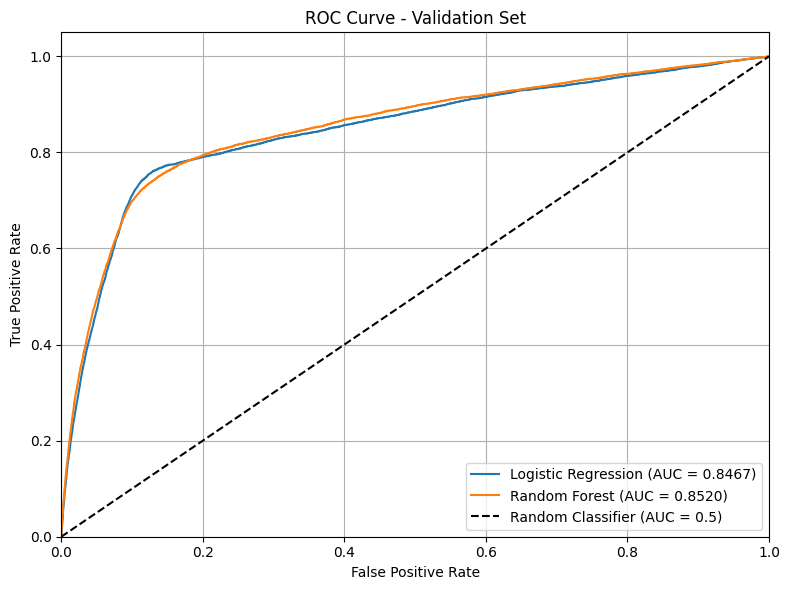

In [81]:
from sklearn.metrics import roc_curve, auc

# ROC curve
fpr_lr, tpr_lr, _ = roc_curve(y_val, lr_val_pred_bo)
roc_auc_lr = auc(fpr_lr, tpr_lr)

fpr_rf, tpr_rf, _ = roc_curve(y_val, rf_val_pred_bo)
roc_auc_rf = auc(fpr_rf, tpr_rf)

plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, label=f"Logistic Regression (AUC = {roc_auc_lr:.4f})")
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {roc_auc_rf:.4f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier (AUC = 0.5)")

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Validation Set')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()
